In [13]:
import cv2
import gym
import itertools
import json
import matplotlib.pylab as plt
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
import torch

from rlpyt.envs.gym import make as gym_make
from rlpyt.models.dqn.grid_dsr_model import GridGoalModel
from rlpyt.utils.seed import set_seed

In [14]:
GRID_SIZE = 19


def normalize_sr(sr_matrix, dim=1):
    return sr_matrix / torch.norm(sr_matrix, dim=dim).reshape(-1, 1)


def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            if isinstance(sr_matrix, np.ndarray):
                grid[y, x] = np.linalg.norm(sr_matrix[y, x] - starting_sr, 2)
            else:
#                 grid[y, x] = torch.norm(sr_matrix[y, x] - starting_sr, 2)
                grid[y, x] = torch.dot(sr_matrix[y, x], starting_sr)
    return grid.T


def visualize_dsr(sr_file, starting_pos=(1, 8), action=-1, normalize=True):
    sr = torch.load(sr_file)
    if action == -1:
        sr_matrix = sr.mean(dim=2)
    else:
        sr_matrix = sr[:, :, action]
    if normalize:
        sr_matrix = sr_matrix / torch.norm(sr_matrix, p=2, dim=2, keepdim=True)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid

In [15]:
folder = '../data/local/20200315/train_sf_goal/run_0/'
folder = '../data/local/20200308/minigrid_test/run_13/'

In [16]:
with open(folder + 'params.json', 'r') as f:
    config = json.load(f)

In [17]:
env = gym_make(id=config['env_id'], mode=config['mode'], minigrid_config=config['env'])

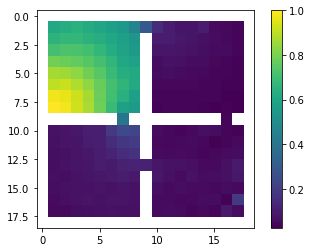

In [18]:
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200308-run13.pt', (1, 8), -1, True)
plt.imshow(dsr_heatmap)
plt.colorbar()

In [19]:
seed = config['seed']
set_seed(seed)

using seed 333


In [20]:
np_dsr = dsr.cpu().detach().numpy()

In [21]:
num_features = 361

In [22]:
raw_s_features = np_dsr.reshape(-1, num_features)
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [23]:
kmedoids = KMedoids(n_clusters=4, random_state=seed).fit(s_features)

In [24]:
centers = kmedoids.medoid_indices_

In [25]:
indices = np.array(list(itertools.product(range(GRID_SIZE), range(GRID_SIZE))))
rooms = np.zeros(361)
rooms[(indices[:, 0] < 9) & (indices[:, 1] < 9)] = 1
rooms[(indices[:, 0] < 9) & (indices[:, 1] > 9)] = 2
rooms[(indices[:, 0] > 9) & (indices[:, 1] < 9)] = 3
rooms[(indices[:, 0] > 9) & (indices[:, 1] > 9)] = 4
rooms = rooms.reshape(GRID_SIZE, GRID_SIZE)

In [26]:
true_centers = indices[~walls][centers]
true_centers

array([[ 4, 12],
       [17, 16],
       [13, 13],
       [ 5, 15]])

In [35]:
center = tuple(true_centers[2])
center

(13, 13)

In [36]:
center = (1, 8)

In [37]:
# subgoal = env.feature_map[center]
subgoal = env.one_hot[center[0] * GRID_SIZE + center[1]]
subgoal = subgoal / np.linalg.norm(subgoal)

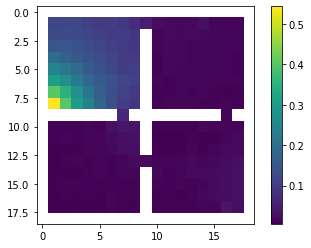

In [38]:
reward = np.matmul(np_dsr, subgoal)
plt.imshow(reward.T)
plt.colorbar()

In [31]:
max_reward_loc = np.nanargmax(reward)

In [32]:
max_reward_loc // GRID_SIZE, max_reward_loc % GRID_SIZE

(13, 13)

In [61]:
env.reset()
obs = env.env.env.step(6)[0]['image']
for _ in range(1000):
    cv2.imshow('image', obs)
    env.step(env.action_space.sample()) # take a random action
    obs = env.env.env.step(6)[0]['image']
    cv2.waitKey(1)
env.close()